<a href="https://colab.research.google.com/github/viniiciusBsilva/DataScience/blob/main/vgg16BreaKHis400x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple vgg16 to classify histopathological images into 2 classes (BreakHis 400x)



---

Data Source: https://www.kaggle.com/datasets/forderation/breakhis-400x

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/BreakHis.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

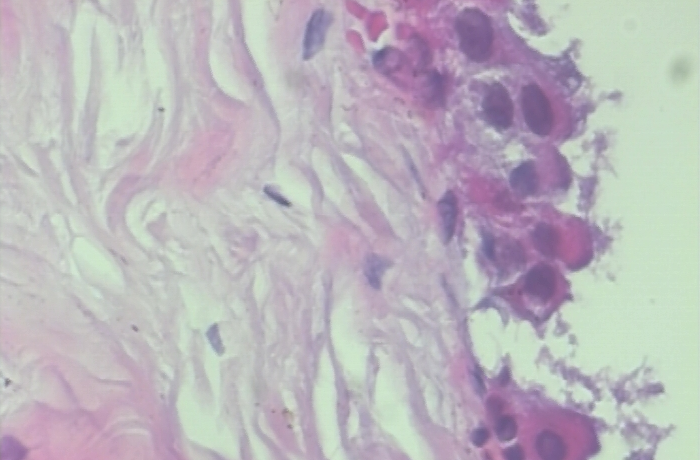

In [ ]:
tf.keras.preprocessing.image.load_img('/content/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png')

In [ ]:
img_size = (224, 224)
batch_size = 32

In [ ]:
gerador_treinamento = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

dataset_treinamento = gerador_treinamento.flow_from_directory('/content/BreaKHis 400X/train',
                                                              target_size = (224, 224),
                                                              batch_size = 32,
                                                              class_mode = 'categorical',
                                                              subset='training',
                                                              shuffle = True)
validation_generator = gerador_treinamento.flow_from_directory(
    '/content/BreaKHis 400X/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 919 images belonging to 2 classes.
Found 229 images belonging to 2 classes.


In [ ]:
dataset_treinamento.class_indices

{'benign': 0, 'malignant': 1}

In [ ]:
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/BreaKHis 400X/test',
                                                  target_size = (224,224),
                                                  batch_size = 16,
                                                  class_mode = 'categorical',
                                                  shuffle=False)

Found 545 images belonging to 2 classes.


In [ ]:
# Carregar modelo pré-treinado no ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Congelar as camadas do modelo pré-treinado
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation = 'softmax'))


# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Exibir resumo do modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                      

In [ ]:

# Treinar o modelo
history = model.fit(
    dataset_treinamento,
    steps_per_epoch=dataset_treinamento.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
28/28 [==============================] - 520s 19s/step - loss: 2.4574 - accuracy: 0.6528 - precision_2: 0.6528 - recall_2: 0.6528 - auc_2: 0.6878 - val_loss: 0.9630 - val_accuracy: 0.5179 - val_precision_2: 0.5179 - val_recall_2: 0.5179 - val_auc_2: 0.5116
Epoch 2/10
28/28 [==============================] - 518s 19s/step - loss: 1.6115 - accuracy: 0.6764 - precision_2: 0.6764 - recall_2: 0.6764 - auc_2: 0.7372 - val_loss: 0.9077 - val_accuracy: 0.6518 - val_precision_2: 0.6518 - val_recall_2: 0.6518 - val_auc_2: 0.6584
Epoch 3/10
28/28 [==============================] - 508s 18s/step - loss: 0.9895 - accuracy: 0.7384 - precision_2: 0.7384 - recall_2: 0.7384 - auc_2: 0.8083 - val_loss: 0.8839 - val_accuracy: 0.6429 - val_precision_2: 0.6429 - val_recall_2: 0.6429 - val_auc_2: 0.6749
Epoch 4/10
28/28 [==============================] - 509s 18s/step - loss: 0.9383 - accuracy: 0.7576 - precision_2: 0.7576 - recall_2: 0.7576 - auc_2: 0.8202 - val_loss: 0.8787 - val_accuracy: 0.67

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix



# Fazer previsões no conjunto de teste
test_predictions = model.predict(dataset_teste)
test_labels = dataset_teste.labels

# Calcular matriz de confusão
conf_matrix = confusion_matrix(test_labels, test_predictions.argmax(axis=1))



# Imprimir relatório de classificação
class_names = list(dataset_teste.class_indices.keys())
print(classification_report(test_labels, test_predictions.argmax(axis=1), target_names=class_names))

# Imprimir matriz de confusão
print('Confusion Matrix:')
print(conf_matrix)

35/35 [==============================] - 219s 6s/step
              precision    recall  f1-score   support

      benign       0.77      0.60      0.67       176
   malignant       0.83      0.92      0.87       369

    accuracy                           0.81       545
   macro avg       0.80      0.76      0.77       545
weighted avg       0.81      0.81      0.81       545

Confusion Matrix:
[[105  71]
 [ 31 338]]


35/35 [==============================] - 227s 6s/step


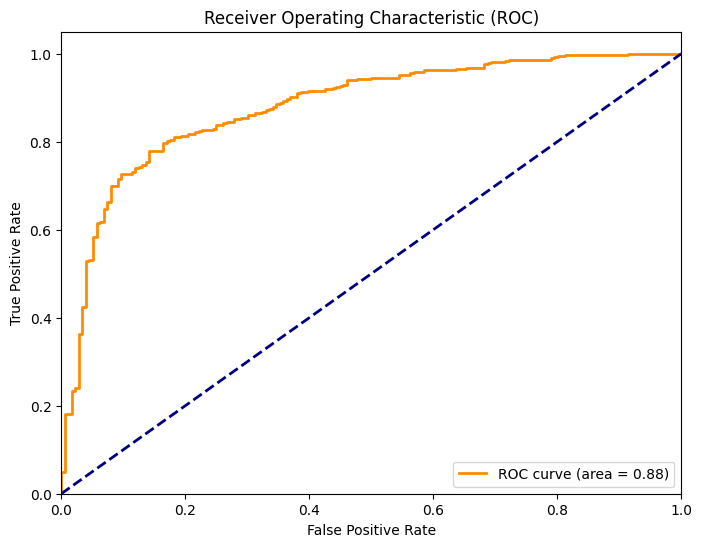

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Fazer previsões no conjunto de teste
test_predictions = model.predict(dataset_teste)

# Extrair as probabilidades da classe positiva (classe 1)
test_probs = test_predictions[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(dataset_teste.labels, test_probs)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Salvar o modelo treinado
model.save('double_transfer_learning_model.h5')
